<a href="https://colab.research.google.com/github/mgorkemuysal/Sentiment140-Twitter-Sentiment-Analysis-Keras-RNN/blob/master/sentiment140_keras_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Downloading and Preparing the Data**
Download Twitter data from Kaggle using kaggle.json file

In [0]:
import os 
os.environ['KAGGLE_USERNAME'] = "mgorkemuysal"
os.environ['KAGGLE_KEY'] = "KAGGLE_KEY_FROM_KAGGLE.JSON"
!kaggle datasets download -d kazanova/sentiment140

 98% 79.0M/80.9M [00:01<00:00, 34.6MB/s]
100% 80.9M/80.9M [00:01<00:00, 54.1MB/s]


In [0]:
from zipfile import ZipFile
with ZipFile('sentiment140.zip', 'r') as zip:
  # zip.printdir()
  zip.extractall()

In [0]:
!ls

sample_data  sentiment140.zip  training.1600000.processed.noemoticon.csv


# **Inspecting Sentiment140 Twitter data**
Sentiment140 dataset contains 1600000 tweets and 6 fields. The fields are target(sentiment), id, date, flag, username and text. Text is tweets which includes special characters(@#., etc.), urls(http://twitter.com etc.) and numbers. We need to clean this text field before construct any model.

In [0]:
import pandas as pd

col_names = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = 'latin-1', names = col_names, header = None)
print('Dataset Size:', len(df))
df.head(10)

Dataset Size: 1600000


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


# **Drop unnecessary fields**
Since our goal is to make sentiment analysis, we should drop unnecessary fields. We do not need any id, date, flag and username to make sentiment analysis. 

In [0]:
df = df.drop(['ids', 'date', 'flag', 'user'], axis = 1)
df.head(10)

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   text    1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


# **Data Preprocessing**
In the data preprocessing phase, we first determine what we want to clean from the tweet text. We need to get rid of special characters, punctuations and english stop words. In natural language processing, useless words(data), are referred to as stop words.

In [0]:
import string
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
import nltk

nltk.download('stopwords')

punc = list(string.punctuation)
print(punc)
stopword_list = stopwords.words('english') + punc + ['rt', 'via', '..', '...']
print(stopword_list)
stemmer = SnowballStemmer('english')
# stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up'

Later, we need to define a regular expression to get rid of twitter mentions(@user_name), hashtags, urls and numbers. We also need a stemmer to find stem of words. Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma. Stemming makes training data more dense. It reduces the size of the dictionary. With less dimensions, training process will give better results. 

In [0]:
import re

TEXT_CLEANING_RE = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'
stop_words = stopwords.words('english')

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return ' '.join(tokens)

# **Testing and Applying preprocessing on Text field**
Before we apply preprocessing on all tweet text field, we should test it on one tweet. Since preprocessing gives the desired result, we can apply it to the entire text field.

In [0]:
sample_tweet = preprocess(df['text'][0])
print('\t--- Before ---\n', df['text'][0])
print('\n\t--- After ---\n', sample_tweet)

	--- Before ---
 @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

	--- After ---
 awww bummer shoulda got david carr third day


In [0]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 42.3 s, sys: 166 ms, total: 42.4 s
Wall time: 42.4 s


In [0]:
df.head(10)

,target,text
0,0,awww bummer shoulda got david carr third day
1,0,upset update facebook texting might cry result...
2,0,dived many times ball managed save 50 rest go ...
3,0,whole body feels itchy like fire
4,0,behaving mad see
5,0,whole crew
6,0,need hug
7,0,hey long time see yes rains bit bit lol fine t...
8,0,nope
9,0,que muera


# **Dataset labels distribution**
According to kaggle metadata, data of target(sentiment) field contains 0 --> negative and 4 --> positive. We should divide all field by 4 to get clear binary classification problem.

In [0]:
df['target'] = df['target'] / 4

Text(0.5, 1.0, 'Dataset labels distribuition')

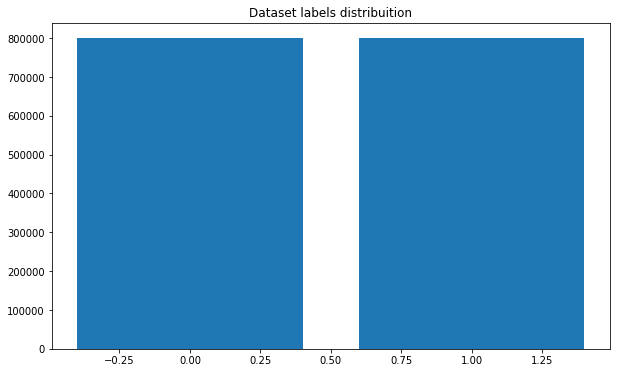

In [0]:
import matplotlib.pyplot as plt
from collections import Counter

target_cnt = Counter(df.target)
plt.figure(figsize=(10,6))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

# **Preparing data for Deep Learning training and test**
Before construct a training model, we need to prepare for it like converting training text into 2d tensors and splitting data as training and test. So first of all, we should split the data as 80% training and 20% test and shuffle them for satisfy randomness like real world.

In [0]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


After splitting the data, we need to convert training text field into 2d tensors. To do this, we need:
- a tokenizer to split text into words,
- texts_to_sequences to turn strings into lists of integer indices,
- pad_sequences to turn the lists of integers intoa 2D integer tensor of shape(training_data , maxlen). maxlen means that cuts off the text after this number of words. 

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Using TensorFlow backend.


Total words 290419


In [0]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=300)

In [0]:
y_train = df_train.target
y_test = df_test.target

print("X_TRAIN size:", len(x_train))
print("Y_TRAIN size:", len(y_train))
print("X_TEST size:", len(x_test))
print("Y_TEST size:", len(y_test))

X_TRAIN size: 1280000
Y_TRAIN size: 1280000
X_TEST size: 320000
Y_TEST size: 320000


In [0]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1280000, 300)
(1280000,)
(320000, 300)
(320000,)


In [0]:
x_train[:10]

array([[    0,     0,     0, ...,   712,   118, 24590],
       [    0,     0,     0, ...,   452,   378, 32447],
       [    0,     0,     0, ...,  2048,     4,  5487],
       ...,
       [    0,     0,     0, ...,   276,   503,   117],
       [    0,     0,     0, ...,   229,   849,  2348],
       [    0,     0,     0, ...,   196,  2063,  1893]], dtype=int32)

In [0]:
y_train[:10]

1374558    1.0
1389115    1.0
1137831    1.0
790714     0.0
1117911    1.0
1077663    1.0
1253991    1.0
1535242    1.0
1396460    1.0
1178954    1.0
Name: target, dtype: float64

# **Building a Network using Embedding Layer**
The Embedding layer is best understood as a dictionary that maps integer indices(which stand for specific words) to dense vectors. It takes integers as input, it looks upthese integers in an internal dictionary, and it returns the associated vectors. It’s effec-tively a dictionary lookup. 
The model consists of one embedding layer that:
- takes 20000 size of vocabulary as input dimension, 
- gives 300 dimension  of the dense embedding as output
- input_length is required to connect Flatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed).

Because we have a binary-classification problem, the model end with 1 unit and sigmoid activation function. And also we need to use binary-crossentropy loss function same reasons.

In [0]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

max_len = 300

model = Sequential()
model.add(Embedding(20000, 300, input_length = max_len))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          6000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 90000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2880032   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 8,880,065
Trainable params: 8,880,065
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=1024,
                    validation_split=0.2) 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1024000 samples, validate on 256000 samples
Epoch 1/10
1024000/1024000 [==============================] - 58s 57us/step - loss: 0.4930 - accuracy: 0.7619 - val_loss: 0.4625 - val_accuracy: 0.7806
Epoch 2/10
1024000/1024000 [==============================] - 57s 55us/step - loss: 0.4483 - accuracy: 0.7887 - val_loss: 0.4589 - val_accuracy: 0.7826
Epoch 3/10
1024000/1024000 [==============================] - 57s 56us/step - loss: 0.4307 - accuracy: 0.7987 - val_loss: 0.4667 - val_accuracy: 0.7799
Epoch 4/10
1024000/1024000 [==============================] - 57s 56us/step - loss: 0.4097 - accuracy: 0.8108 - val_loss: 0.4791 - val_accuracy: 0.7780
Epoch 5/10
1024000/1024000 [==============================] - 57s 56us/step - loss: 0.3889 - accuracy: 0.8231 - val_loss: 0.4906 - val_accuracy: 0.7729
Epoch 6/10
1024000/1024000 [==============================] - 57s 56us/step - loss: 0.3684 - accuracy: 0.8346 - val_loss: 0.5162 - val_accuracy: 0.7647
Epoch 7/10
1024000/1024000 [=======

# **Visualizing the Performance of the Model**
We can clearly see that the model is overfitting (High accuracy - Low Loss and Low Validation Accuracy - High Validation Loss). The reasons why the model is overfitting may be:
- insufficient embedding vector space(we should try pretrained word embeddings).
- the model suffers from not having any memory to remember all sentence structure(we should try an LSTM model).

Let's try these methods to construct a better model.


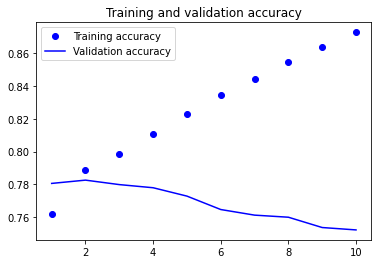

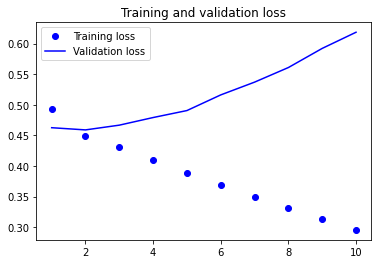

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# **Using Pretrained Word Embedding**
To solve first overfitting reason defined above, we should construct a embedding layer with pretrained Word2vec word embedding. A Word2vec model should include the words of our training text. So, we must construct a Word2vec model and train that model with the words of training text.

In [0]:
import gensim

documents = [text.split() for text in df_train.text]
w2v_model = gensim.models.word2vec.Word2Vec(size=300, 
                                            window=7, 
                                            min_count=10, 
                                            workers=8)
w2v_model.build_vocab(documents)

In [0]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [0]:
w2v_model.wv['model'].shape

(300,)

In [0]:
w2v_model.train(documents, total_examples=len(documents), epochs=32)

(263117863, 295270528)

In [0]:
w2v_model.save('model.w2v')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
w2v_model.most_similar('love')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('luv', 0.5742346048355103),
 ('loves', 0.546484649181366),
 ('loved', 0.5442296862602234),
 ('adore', 0.5271387696266174),
 ('amazing', 0.5061094760894775),
 ('looove', 0.49339559674263),
 ('loveee', 0.47563421726226807),
 ('lovee', 0.4687182307243347),
 ('awesome', 0.4623849391937256),
 ('loooove', 0.44378846883773804)]

In [0]:
w2v_model.most_similar('world')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('earth', 0.4466097354888916),
 ('life', 0.39991867542266846),
 ('worlds', 0.38926005363464355),
 ('twitterverse', 0.3507654368877411),
 ('planet', 0.34573227167129517),
 ('ever', 0.3001565635204315),
 ('heartedly', 0.2970462143421173),
 ('universe', 0.29703855514526367),
 ('europe', 0.2895945906639099),
 ('individuals', 0.2860460877418518)]

Next, we need to build an embedding matrix that we can load into an Embedding layer. It must be a matrix of shape (max_words, embedding_dim), where each entry i contains the 300-dimensional vector for the word of index i in the reference word index (built during tokenization). This embedding matrix will be the weights of the new embedding layer. In this way, we construct an embedding layer from pretrained word embeddings. Additionally, we need to freeze the Embedding layer(set its trainable attribute to False) for preventing pretrained network weights from being updated during training.

In [0]:
import numpy as np

vocab_size = 290419 # from tokenizer

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [0]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
flatten_2 (Flatten)          (None, 90000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2880032   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 90,005,765
Trainable params: 2,880,065
Non-trainable params: 87,125,700
_________________________________________________________________


In [0]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=1024,
                    validation_split=0.2)

Train on 1024000 samples, validate on 256000 samples
Epoch 1/10
1024000/1024000 [==============================] - 32s 31us/step - loss: 0.4875 - accuracy: 0.7624 - val_loss: 0.4751 - val_accuracy: 0.7706
Epoch 2/10
1024000/1024000 [==============================] - 32s 31us/step - loss: 0.4617 - accuracy: 0.7788 - val_loss: 0.4730 - val_accuracy: 0.7718
Epoch 3/10
1024000/1024000 [==============================] - 32s 31us/step - loss: 0.4470 - accuracy: 0.7883 - val_loss: 0.4739 - val_accuracy: 0.7721
Epoch 4/10
1024000/1024000 [==============================] - 32s 31us/step - loss: 0.4353 - accuracy: 0.7955 - val_loss: 0.4785 - val_accuracy: 0.7705
Epoch 5/10
1024000/1024000 [==============================] - 32s 31us/step - loss: 0.4257 - accuracy: 0.8012 - val_loss: 0.4843 - val_accuracy: 0.7689
Epoch 6/10
1024000/1024000 [==============================] - 32s 31us/step - loss: 0.4176 - accuracy: 0.8058 - val_loss: 0.4895 - val_accuracy: 0.7675
Epoch 7/10
1024000/1024000 [=======

# **Visualizing the Performance of the Model**
Although we added pretrained word embedding, the model is still overfitting. The reasons why the model is overfitting may be:
- the model suffers from not having any memory to remember all sentence structure(we should try to add an LSTM model and dropout)

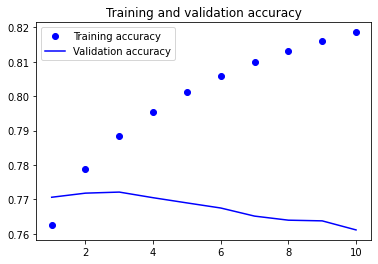

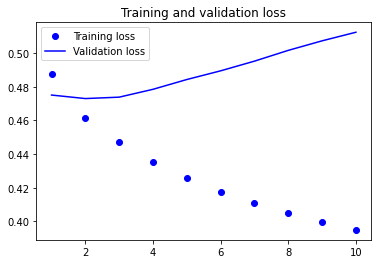

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# **Using LSTM layer with pretrained Embedding layer and dropouts**
Models we created earlier suffers from remembering problem. Imagine that you read a book word by word and you do not remember what the previous word is. So you can not learn from this book. LSTM layer solves remembering problem for us. Imagine a conveyor belt running parallel to the sequence you are processing. Information from the sequence can jump onto the conveyor  belt  at  any  point,  be  transported  to  a  later  timestep,  and  jump  off,  intact,when  you  need  it.  This  is  essentially  what  LSTM  does:  it  saves  information  for  later,thus preventing older signals from gradually vanishing during processing. To fight overfitting we need to construct a model with the pretrained embedding layer and an lstm layer that includes dropout and recurrent dropout.
- dropout,  a  float  specifying  the  dropout  rate  for  input  units  of  the  layer
- recurrent_dropout, specifying the dropout rate of the recurrent units

 

In [0]:
from keras.layers import LSTM

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [0]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=1024,
                    validation_split=0.2)

Train on 1024000 samples, validate on 256000 samples
Epoch 1/10
1024000/1024000 [==============================] - 758s 740us/step - loss: 0.4773 - accuracy: 0.7696 - val_loss: 0.4490 - val_accuracy: 0.7869
Epoch 2/10
1024000/1024000 [==============================] - 752s 734us/step - loss: 0.4491 - accuracy: 0.7865 - val_loss: 0.4400 - val_accuracy: 0.7924
Epoch 3/10
1024000/1024000 [==============================] - 803s 784us/step - loss: 0.4386 - accuracy: 0.7930 - val_loss: 0.4364 - val_accuracy: 0.7947
Epoch 4/10
1024000/1024000 [==============================] - 801s 782us/step - loss: 0.4322 - accuracy: 0.7969 - val_loss: 0.4357 - val_accuracy: 0.7952
Epoch 5/10
1024000/1024000 [==============================] - 806s 787us/step - loss: 0.4269 - accuracy: 0.7998 - val_loss: 0.4330 - val_accuracy: 0.7965
Epoch 6/10
1024000/1024000 [==============================] - 789s 770us/step - loss: 0.4308 - accuracy: 0.7979 - val_loss: 0.4340 - val_accuracy: 0.7970
Epoch 7/10
1024000/1024

# **Visualizing the Performance of the Model**
Thanks to the lstm layer with droputs, we can say that the new model is not overfitting (accuracy - vall_accuracy and loss - val_loss are similar). We can take this model as a solution. But let's investigate what happens when we add more(stacking) sequential lstm layer. 

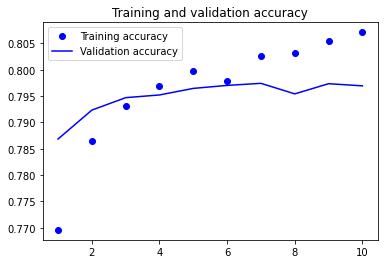

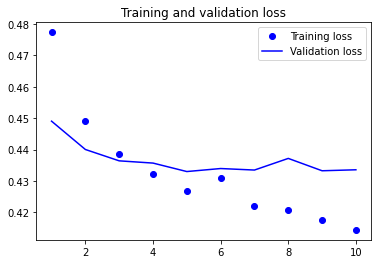

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
model.save('lstm_model.h5')

# **Using Recurrent layer Stacking with CuDNNLSTM**
Since ordinary lstm models take too much time to train(estimation training time of 3 lstm layer for our problem is near 10 hours), let's use CuDNNLSTM layer for recurrent layer stacking. CuDNNLSTM uses NVIDIA cuDNN technology to train neural networks fast (https://developer.nvidia.com/cudnn) and it RUNS ONLY ON GPUs. Let's define 3 CuDNNLSTM layer to investigate whether recurrent layer stacking is better or not. return_sequences = True means that return the last output. 

In [0]:
!pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [0]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [0]:
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense

model_cudnn = Sequential()
model_cudnn.add(embedding_layer)
model_cudnn.add(CuDNNLSTM(32, return_sequences = True))
model_cudnn.add(CuDNNLSTM(64, return_sequences = True))
model_cudnn.add(CuDNNLSTM(128))
model_cudnn.add(Dense(1, activation = 'sigmoid'))

model_cudnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
cu_dnnlstm_7 (CuDNNLSTM)     (None, 300, 32)           42752     
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, 300, 64)           25088     
_________________________________________________________________
cu_dnnlstm_9 (CuDNNLSTM)     (None, 128)               99328     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 87,292,997
Trainable params: 167,297
Non-trainable params: 87,125,700
_________________________________________________________________


In [0]:
model_cudnn.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [0]:
history_cudnn = model_cudnn.fit(x_train, y_train,
                    epochs=10,
                    batch_size=1024,
                    validation_split=0.2)

Epoch 1/10
1000/1000 [==============================] - 548s 548ms/step - loss: 0.4674 - accuracy: 0.7760 - val_loss: 0.4506 - val_accuracy: 0.7859
Epoch 2/10
1000/1000 [==============================] - 549s 549ms/step - loss: 0.4427 - accuracy: 0.7909 - val_loss: 0.4447 - val_accuracy: 0.7903
Epoch 3/10
1000/1000 [==============================] - 548s 548ms/step - loss: 0.4349 - accuracy: 0.7956 - val_loss: 0.4405 - val_accuracy: 0.7924
Epoch 4/10
1000/1000 [==============================] - 547s 547ms/step - loss: 0.4284 - accuracy: 0.7994 - val_loss: 0.4398 - val_accuracy: 0.7929
Epoch 5/10
1000/1000 [==============================] - 549s 549ms/step - loss: 0.4240 - accuracy: 0.8020 - val_loss: 0.4383 - val_accuracy: 0.7932
Epoch 6/10
1000/1000 [==============================] - 548s 548ms/step - loss: 0.4205 - accuracy: 0.8041 - val_loss: 0.4378 - val_accuracy: 0.7931
Epoch 7/10
1000/1000 [==============================] - 547s 547ms/step - loss: 0.4174 - accuracy: 0.8057 - val_

# **Visualizing the Performance of the Model**

Thanks to the CuDNNLSTM layers, we can say that the new model is nearly same previous LSTM model. But computational time of CuDNNLSTM is half of previous lstm model (2 hours vs 1 hour). Also we have nearly same accuracy - validation accuracy - test scores. So that, we can take this model as a solution model for our problem.

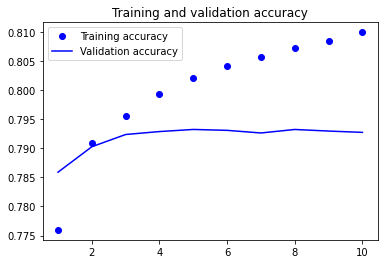

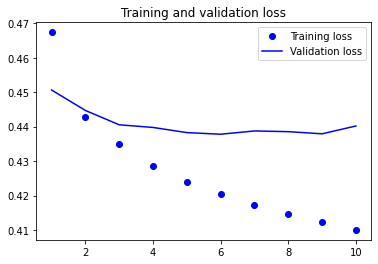

In [0]:
acc = history_cudnn.history['accuracy']
val_acc = history_cudnn.history['val_accuracy']
loss = history_cudnn.history['loss']
val_loss = history_cudnn.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
score = model_cudnn.evaluate(x_test, y_test, batch_size=1024)
print('\n--- TEST SCORE ---')
print("Accuracy:", score[1])
print("Loss:", score[0])

313/313 [==============================] - 71s 226ms/step - loss: 0.4399 - accuracy: 0.7937

--- TEST SCORE ---
Accuracy: 0.7937343716621399
Loss: 0.43990108370780945


# **Test the Model with Sample Sentences**
Let's test our model with sample sentences to find out whether the sentence is positive or negative.

In [0]:
def decode_sentiment(score):
  if score < 0.5:
    return 'Negative'
  else:
    return 'Positive'

In [0]:
def predict_tweet(text):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen = 300)
    # Predict
    score = model_cudnn.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score)}

In [0]:
predict_tweet('I love the music')

{'label': 'Positive', 'score': 0.9732761979103088}

In [0]:
predict_tweet('I hate dogs')

{'label': 'Negative', 'score': 0.0392216257750988}

In [0]:
predict_tweet('The weather is rainy tomorrow')

{'label': 'Negative', 'score': 0.03448782116174698}

In [0]:
predict_tweet('my cat is so stupid')

{'label': 'Negative', 'score': 0.16725490987300873}

In [0]:
predict_tweet('i have two tickets to the Iron Maiden concert')

{'label': 'Positive', 'score': 0.6529272198677063}

In [0]:
predict_tweet('I have a ticket to the Slayer concert')

{'label': 'Positive', 'score': 0.747378945350647}